In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import imblearn.over_sampling
from sklearn.svm import SVC
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, roc_auc_score
import pickle
from copy import deepcopy

In [2]:
#import the dataframe pickled after importing w/ SQLAlchemy
with open('wine_df_from_sql.p','rb') as read_file:
    df_wines = pickle.load(read_file)

In [3]:
df_wines

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2,total_so2,density,ph,sulphates,alcohol,quality,variety,goodbad,unfree_so2
0,8.6,0.33,0.34,11.80,0.059,42.0,240.0,0.99882,3.17,0.52,10.0,6,1.0,False,198.0
1,6.8,0.17,0.34,2.00,0.040,38.0,111.0,0.99000,3.24,0.45,12.9,6,1.0,False,73.0
2,6.0,0.26,0.29,3.10,0.041,37.0,144.0,0.98944,3.22,0.39,12.8,7,1.0,True,107.0
3,8.6,0.36,0.26,11.10,0.030,43.5,171.0,0.99480,3.03,0.49,12.0,5,1.0,False,127.5
4,7.0,0.22,0.31,2.70,0.030,41.0,136.0,0.98980,3.16,0.37,12.7,7,1.0,True,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,7.4,0.33,0.26,2.60,0.040,29.0,115.0,0.99130,3.07,0.52,11.8,7,1.0,True,86.0
5316,6.4,0.15,0.36,1.80,0.034,43.0,150.0,0.99220,3.42,0.69,11.0,8,1.0,True,107.0
5317,6.8,0.21,0.27,18.15,0.042,41.0,146.0,1.00010,3.30,0.36,8.7,5,1.0,False,105.0
5318,7.4,0.28,0.42,19.80,0.066,53.0,195.0,1.00000,2.96,0.44,9.1,5,1.0,False,142.0


In [4]:
#drop quality, since I'm only looking at binary good/bad now
df_wines = df_wines.drop(['quality'], axis = 1)

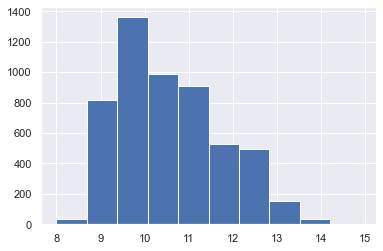

In [5]:
#some checks that data is clean and normal-looking
df_wines.isna().sum()
df_wines.fixed_acidity.describe()
df_wines.density.describe()
df_wines.alcohol.describe()
plt.hist(df_wines['alcohol']);

In [6]:
#alcohol looks skewed, so let's log transform it to try and improve the model
df_wines['alcohol'] = np.log2(df_wines['alcohol'])

In [7]:
df_wines['goodbad'] = df_wines['goodbad'].astype(int)

In [8]:
#columns used in modeling
X_cols = ['fixed_acidity','volatile_acidity','citric_acid','residual_sugar',
       'chlorides','free_so2','density','ph','sulphates',
       'alcohol','variety','total_so2']

In [9]:
X = df_wines[X_cols]
y = df_wines['goodbad']

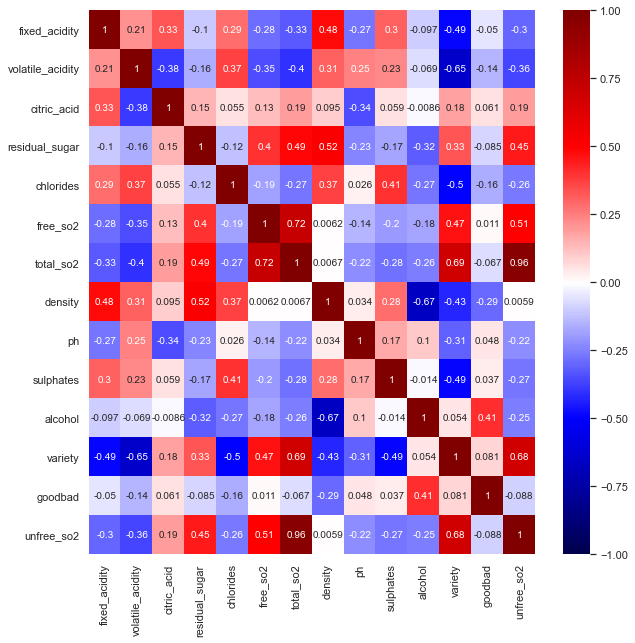

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_wines.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [11]:
#sns.pairplot(df_wines, height=1.2, aspect=1.5);

In [12]:
#LIST VERSION
#Initialize lists for each model and score combination

dummy_train_f1, dummy_val_f1 = [],[]
dummy_train_ROC, dummy_val_ROC = [],[]
dummy_train_precision, dummy_val_precision = [],[]
dummy_train_recall, dummy_val_recall = [],[]

knn_train_f1, knn_val_f1 = [],[]
knn_train_ROC, knn_val_ROC = [],[]
knn_train_precision, knn_val_precision = [],[]
knn_train_recall, knn_val_recall = [],[]

logreg_train_f1, logreg_val_f1 = [],[]
logreg_train_ROC, logreg_val_ROC = [],[]
logreg_train_precision, logreg_val_precision = [],[]
logreg_train_recall, logreg_val_recall = [],[]

dtree_train_f1, dtree_val_f1 = [],[]
dtree_train_ROC, dtree_val_ROC = [],[]
dtree_train_precision, dtree_val_precision = [],[]
dtree_train_recall, dtree_val_recall = [],[]

rf_train_f1, rf_val_f1 = [],[]
rf_train_ROC, rf_val_ROC = [],[]
rf_train_precision, rf_val_precision = [],[]
rf_train_recall, rf_val_recall = [],[]

svm_train_f1, svm_val_f1 = [],[]
svm_train_ROC, svm_val_ROC = [],[]
svm_train_precision, svm_val_precision = [],[]
svm_train_recall, svm_val_recall = [],[]

nb_train_f1, nb_val_f1 = [],[]
nb_train_ROC, nb_val_ROC = [],[]
nb_train_precision, nb_val_precision = [],[]
nb_train_recall, nb_val_recall = [],[]

In [13]:
#LIST VERSION
#split data into train_val for CV and test for final model
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state = 23)

X_train_val, y_train_val = np.array(X_train_val), np.array(y_train_val)
X_test, y_test = np.array(X_test), np.array(y_test)
skf = StratifiedKFold(n_splits = 5, random_state = 23, shuffle = True)

#CV
for train, val in skf.split(X_train_val, y_train_val):
    X_train, y_train = X_train_val[train], y_train_val[train]
    X_val, y_val = X_train_val[val], y_train_val[val]
    
    #scale features by fitting scaler to train
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    #create each model (dummy, KNN, log. regress., decision tree, random forest, and SVM)
    
    dummy_model = DummyClassifier(strategy="most_frequent")
    dummy_model.fit(X_train_scaled, y_train) 
    
    knn_model = KNeighborsClassifier(n_neighbors = 5)
    knn_model.fit(X_train_scaled, y_train)
    
    logreg_model = LogisticRegression(C = 1)
    logreg_model.fit(X_train_scaled, y_train)
    
    dtree_model = DecisionTreeClassifier(max_depth=4)
    dtree_model.fit(X_train_scaled, y_train)
    
    rf_model = RandomForestClassifier(random_state = 23)
    rf_model.fit(X_train_scaled, y_train)
    
    svm_model = SVC(kernel='poly', gamma='auto', probability = True)
    svm_model.fit(X_train_scaled, y_train)
    
    nb_model = GaussianNB()
    nb_model.fit(X_train_scaled, y_train)
    
    #add scores from each CV round to appropriate lists
    
    dummy_train_f1.append(f1_score(y_train, dummy_model.predict(X_train_scaled)))
    dummy_val_f1.append(f1_score(y_val, dummy_model.predict(X_val_scaled)))
    dummy_train_ROC.append(roc_auc_score(y_train, dummy_model.predict_proba(X_train_scaled)[:,1]))
    dummy_val_ROC.append(roc_auc_score(y_val, dummy_model.predict_proba(X_val_scaled)[:,1]))
    dummy_train_precision.append(precision_score(y_train, dummy_model.predict(X_train_scaled)))
    dummy_val_precision.append(precision_score(y_val, dummy_model.predict(X_val_scaled)))
    dummy_train_recall.append(recall_score(y_train, dummy_model.predict(X_train_scaled)))
    dummy_val_recall.append(recall_score(y_val, dummy_model.predict(X_val_scaled)))
    
    knn_train_f1.append(f1_score(y_train, knn_model.predict(X_train_scaled)))
    knn_val_f1.append(f1_score(y_val, knn_model.predict(X_val_scaled)))
    knn_train_ROC.append(roc_auc_score(y_train, knn_model.predict_proba(X_train_scaled)[:,1]))
    knn_val_ROC.append(roc_auc_score(y_val, knn_model.predict_proba(X_val_scaled)[:,1]))
    knn_train_precision.append(precision_score(y_train, knn_model.predict(X_train_scaled)))
    knn_val_precision.append(precision_score(y_val, knn_model.predict(X_val_scaled)))
    knn_train_recall.append(recall_score(y_train, knn_model.predict(X_train_scaled)))
    knn_val_recall.append(recall_score(y_val, knn_model.predict(X_val_scaled)))
    
    logreg_train_f1.append(f1_score(y_train, logreg_model.predict(X_train_scaled)))
    logreg_val_f1.append(f1_score(y_val, logreg_model.predict(X_val_scaled)))
    logreg_train_ROC.append(roc_auc_score(y_train, logreg_model.predict_proba(X_train_scaled)[:,1]))
    logreg_val_ROC.append(roc_auc_score(y_val, logreg_model.predict_proba(X_val_scaled)[:,1]))
    logreg_train_precision.append(precision_score(y_train, logreg_model.predict(X_train_scaled)))
    logreg_val_precision.append(precision_score(y_val, logreg_model.predict(X_val_scaled)))
    logreg_train_recall.append(recall_score(y_train, logreg_model.predict(X_train_scaled)))
    logreg_val_recall.append(recall_score(y_val, logreg_model.predict(X_val_scaled)))
    
    dtree_train_f1.append(f1_score(y_train, dtree_model.predict(X_train_scaled)))
    dtree_val_f1.append(f1_score(y_val, dtree_model.predict(X_val_scaled)))
    dtree_train_ROC.append(roc_auc_score(y_train, dtree_model.predict_proba(X_train_scaled)[:,1]))
    dtree_val_ROC.append(roc_auc_score(y_val, dtree_model.predict_proba(X_val_scaled)[:,1]))
    dtree_train_precision.append(precision_score(y_train, dtree_model.predict(X_train_scaled)))
    dtree_val_precision.append(precision_score(y_val, dtree_model.predict(X_val_scaled)))
    dtree_train_recall.append(recall_score(y_train, dtree_model.predict(X_train_scaled)))
    dtree_val_recall.append(recall_score(y_val, dtree_model.predict(X_val_scaled)))
    
    rf_train_f1.append(f1_score(y_train, rf_model.predict(X_train_scaled)))
    rf_val_f1.append(f1_score(y_val, rf_model.predict(X_val_scaled)))
    rf_train_ROC.append(roc_auc_score(y_train, rf_model.predict(X_train_scaled)))
    rf_val_ROC.append(roc_auc_score(y_val, rf_model.predict(X_val_scaled)))
    rf_train_precision.append(precision_score(y_train, rf_model.predict(X_train_scaled)))
    rf_val_precision.append(precision_score(y_val, rf_model.predict(X_val_scaled)))
    rf_train_recall.append(recall_score(y_train, rf_model.predict(X_train_scaled)))
    rf_val_recall.append(recall_score(y_val, rf_model.predict(X_val_scaled)))
    
    svm_train_f1.append(f1_score(y_train, svm_model.predict(X_train_scaled)))
    svm_val_f1.append(f1_score(y_val, svm_model.predict(X_val_scaled)))
    svm_train_ROC.append(roc_auc_score(y_train, svm_model.predict_proba(X_train_scaled)[:,1]))
    svm_val_ROC.append(roc_auc_score(y_val, svm_model.predict_proba(X_val_scaled)[:,1]))
    svm_train_precision.append(precision_score(y_train, svm_model.predict(X_train_scaled)))
    svm_val_precision.append(precision_score(y_val, svm_model.predict(X_val_scaled)))
    svm_train_recall.append(recall_score(y_train, svm_model.predict(X_train_scaled)))
    svm_val_recall.append(recall_score(y_val, svm_model.predict(X_val_scaled)))
    
    nb_train_f1.append(f1_score(y_train, nb_model.predict(X_train_scaled)))
    nb_val_f1.append(f1_score(y_val, nb_model.predict(X_val_scaled)))
    nb_train_ROC.append(roc_auc_score(y_train, nb_model.predict_proba(X_train_scaled)[:,1]))
    nb_val_ROC.append(roc_auc_score(y_val, nb_model.predict_proba(X_val_scaled)[:,1]))
    nb_train_precision.append(precision_score(y_train, nb_model.predict(X_train_scaled)))
    nb_val_precision.append(precision_score(y_val, nb_model.predict(X_val_scaled)))
    nb_train_recall.append(recall_score(y_train, nb_model.predict(X_train_scaled)))
    nb_val_recall.append(recall_score(y_val, nb_model.predict(X_val_scaled)))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification

In [14]:
#see each model's mean CV scores
print('Dummy Scores (Train):')
print('F1: ', np.mean(dummy_train_f1))
print('ROC: ', np.mean(dummy_train_ROC))
print('Precision: ', np.mean(dummy_train_precision))
print('Recall: ', np.mean(dummy_train_recall))
print('-----------------------------')

print('KNN Scores (Train):')
print('F1: ', np.mean(knn_train_f1))
print('ROC: ', np.mean(knn_train_ROC))
print('Precision: ', np.mean(knn_train_precision))
print('Recall: ', np.mean(knn_train_recall))
print('-----------------------------')

print('Logistic Regression Scores (Train):')
print('F1: ', np.mean(logreg_train_f1))
print('ROC: ', np.mean(logreg_train_ROC))
print('Precision: ', np.mean(logreg_train_precision))
print('Recall: ', np.mean(logreg_train_recall))
print('-----------------------------')

print('Decision Tree Scores (Train):')
print('F1: ', np.mean(dtree_train_f1))
print('ROC: ', np.mean(dtree_train_ROC))
print('Precision: ', np.mean(dtree_train_precision))
print('Recall: ', np.mean(dtree_train_recall))
print('-----------------------------')

print('Random Forest Scores (Train):')
print('F1: ', np.mean(rf_train_f1))
print('ROC: ', np.mean(rf_train_ROC))
print('Precision: ', np.mean(rf_train_precision))
print('Recall: ', np.mean(rf_train_recall))
print('-----------------------------')

print('SVM Scores (Train):')
print('F1: ', np.mean(svm_train_f1))
print('ROC: ', np.mean(svm_train_ROC))
print('Precision: ', np.mean(svm_train_precision))
print('Recall: ', np.mean(svm_train_recall))
print('-----------------------------')

print('Naive Bayes Scores (Train):')
print('F1: ', np.mean(nb_train_f1))
print('ROC: ', np.mean(nb_train_ROC))
print('Precision: ', np.mean(nb_train_precision))
print('Recall: ', np.mean(nb_train_recall))
print('-----------------------------')

print('-----------------------------')

print('Dummy Scores (Validation):')
print('F1: ', np.mean(dummy_val_f1))
print('ROC: ', np.mean(dummy_val_ROC))
print('Precision: ', np.mean(dummy_val_precision))
print('Recall: ', np.mean(dummy_val_recall))
print('-----------------------------')

print('KNN Scores (Validation):')
print('F1: ', np.mean(knn_val_f1))
print('ROC: ', np.mean(knn_val_ROC))
print('Precision: ', np.mean(knn_val_precision))
print('Recall: ', np.mean(knn_val_recall))
print('-----------------------------')

print('Logistic Regression Scores (Validation):')
print('F1: ', np.mean(logreg_val_f1))
print('ROC: ', np.mean(logreg_val_ROC))
print('Precision: ', np.mean(logreg_val_precision))
print('Recall: ', np.mean(logreg_val_recall))
print('-----------------------------')

print('Decision Tree Scores (Validation):')
print('F1: ', np.mean(dtree_val_f1))
print('ROC: ', np.mean(dtree_val_ROC))
print('Precision: ', np.mean(dtree_val_precision))
print('Recall: ', np.mean(dtree_val_recall))
print('-----------------------------')

print('Random Forest Scores (Validation):')
print('F1: ', np.mean(rf_val_f1))
print('ROC: ', np.mean(rf_val_ROC))
print('Precision: ', np.mean(rf_val_precision))
print('Recall: ', np.mean(rf_val_recall))
print('-----------------------------')

print('SVM Scores (Validation):')
print('F1: ', np.mean(svm_val_f1))
print('ROC: ', np.mean(svm_val_ROC))
print('Precision: ', np.mean(svm_val_precision))
print('Recall: ', np.mean(svm_val_recall))
print('-----------------------------')

print('Naive Bayes Scores (Validation):')
print('F1: ', np.mean(nb_val_f1))
print('ROC: ', np.mean(nb_val_ROC))
print('Precision: ', np.mean(nb_val_precision))
print('Recall: ', np.mean(nb_val_recall))

Dummy Scores (Train):
F1:  0.0
ROC:  0.5
Precision:  0.0
Recall:  0.0
-----------------------------
KNN Scores (Train):
F1:  0.632578185484759
ROC:  0.9224608037158948
Precision:  0.7357505258869931
Recall:  0.5553231357084247
-----------------------------
Logistic Regression Scores (Train):
F1:  0.39839022485195574
ROC:  0.8334347725239368
Precision:  0.5732174842889353
Recall:  0.30532497275054193
-----------------------------
Decision Tree Scores (Train):
F1:  0.42095829490944575
ROC:  0.8300558840977782
Precision:  0.6726896757999594
Recall:  0.31475634698051513
-----------------------------
Random Forest Scores (Train):
F1:  1.0
ROC:  1.0
Precision:  1.0
Recall:  1.0
-----------------------------
SVM Scores (Train):
F1:  0.3829556339139841
ROC:  0.8599054511244468
Precision:  0.7765564308631367
Recall:  0.25455280271392355
-----------------------------
Naive Bayes Scores (Train):
F1:  0.48983933628282034
ROC:  0.777063589792686
Precision:  0.3864986830721627
Recall:  0.66912177139

In [15]:
#scale once more to my train_val set
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
    
rf_model.fit(X_train_val_scaled, y_train_val)

RandomForestClassifier(random_state=23)

In [16]:
#"Final" model scores - pre-SMOTE to compare with post-SMOTE
print(f1_score(y_test, rf_model.predict(X_test_scaled)))
print(roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:,1]))
print(recall_score(y_test, rf_model.predict(X_test_scaled)))
print(precision_score(y_test, rf_model.predict(X_test_scaled)))


0.44924406047516197
0.8430099402024518
0.3525423728813559
0.6190476190476191


In [17]:
# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train_val == 1)
n_neg = np.sum(y_train_val == 0)
ratio = {1 : n_pos * 4, 0 : n_neg}

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 23)
X_tr_smote, y_tr_smote = smote.fit_sample(X_train_val_scaled, y_train_val)

rf_smote = deepcopy(rf_model)
rf_smote.fit(X_tr_smote, y_tr_smote)

print('Random Forest on SMOTE Train-Val Data' + '\n' + '=====================================' + '\n' 
      + 'Test F1: %.4f, Test AUC: %.4f, Test Prec: %.4f, Test Recall: %.4f' % \
      (f1_score(y_test, rf_smote.predict(X_test_scaled)),
       roc_auc_score(y_test, rf_smote.predict_proba(X_test_scaled)[:,1]),
       precision_score(y_test, rf_smote.predict(X_test_scaled)),
       recall_score(y_test, rf_smote.predict(X_test_scaled))))

Random Forest on SMOTE Train-Val Data
Test F1: 0.5608, Test AUC: 0.8507, Test Prec: 0.5373, Test Recall: 0.5864


In [18]:
#pickle.dump(df_wines, open("sl_wine_df.p", "wb"))

In [19]:
#pickling for streamlit
#pickle.dump(rf_smote, open("sl_wine_model.p", "wb"))